In [1]:
# ======================
# 1. Install & Setup
# ======================
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Download Spark from Apache archive
!wget -q https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz -O /content/spark-3.5.1-bin-hadoop3.tgz

# Extract Spark
!tar -xzf /content/spark-3.5.1-bin-hadoop3.tgz -C /content/

# Install Python dependencies, with the correct spark-nlp version
!pip install -q findspark pyspark==3.5.1 spark-nlp==5.3.3 datasets

import os, findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"
findspark.init()

# Use sparknlp.start() to create the Spark session
import sparknlp
spark = sparknlp.start()
print("Spark session started successfully with Spark NLP support.")

# The rest of your imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from datasets import load_dataset
from pyspark.sql.types import IntegerType, StringType, StructField, StructType

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.4/568.4 kB 11.2 MB/s eta 0:00:00
Spark session started successfully with Spark NLP support.


In [2]:
# ======================
# 2. Download Sentiment140
# ======================
import urllib.request, zipfile

url = "http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip"
urllib.request.urlretrieve(url, "sentiment140.zip")

with zipfile.ZipFile("sentiment140.zip", "r") as zip_ref:
    zip_ref.extractall(".")

schema = "target INT, id STRING, date STRING, query STRING, user STRING, text STRING"
df_sentiment140 = spark.read.csv("training.1600000.processed.noemoticon.csv", schema=schema, header=False)

# Map labels: 0 -> negative, 4 -> positive
from pyspark.sql.functions import when
df_sentiment140 = df_sentiment140.withColumn(
    "label", when(df_sentiment140.target == 4, 1).otherwise(0)
).select("label", "text")

print("Sentiment140 loaded with", df_sentiment140.count(), "rows.")


Sentiment140 loaded with 1600000 rows.


In [3]:
# ======================
# 3. Load TweetEval (Emotion)
# ======================
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("tweet_eval", "emotion")
train_pd = dataset["train"].to_pandas()
test_pd = dataset["test"].to_pandas()
full_pd = pd.concat([train_pd, test_pd], ignore_index=True)

# Convert to Spark DF
df_tweeteval = spark.createDataFrame(full_pd.rename(columns={"label": "label_id"}))

# Map integer labels to emotion names
label_map = {
    0: "anger",
    1: "joy",
    2: "optimism",
    3: "sadness"
}
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
map_udf = udf(lambda x: label_map[x], StringType())
df_tweeteval = df_tweeteval.withColumn("label", map_udf(df_tweeteval.label_id)).select("label", "text")

print("TweetEval loaded with", df_tweeteval.count(), "rows.")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

emotion/train-00000-of-00001.parquet:   0%|          | 0.00/233k [00:00<?, ?B/s]

emotion/test-00000-of-00001.parquet:   0%|          | 0.00/105k [00:00<?, ?B/s]

emotion/validation-00000-of-00001.parque(…):   0%|          | 0.00/28.6k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3257 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1421 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/374 [00:00<?, ? examples/s]

TweetEval loaded with 4678 rows.


In [4]:
# # ======================
# # 4. Preprocessing Function
# # ======================
# import re
# from pyspark.sql.functions import udf, col
# from pyspark.sql.types import StringType

# def clean_text(text):
#     if text is None:
#         return None
#     text = re.sub(r"http\S+|www\S+", "", text)  # remove URLs
#     text = re.sub(r"@\w+", "", text)           # remove mentions
#     text = re.sub(r"#", "", text)              # remove hashtag symbol
#     text = re.sub(r"[^A-Za-z\s]", "", text)    # keep only letters
#     text = text.lower().strip()
#     return text if text else None

# clean_udf = udf(clean_text, StringType())

# def preprocess_df(df):
#     return df.withColumn("clean_text", clean_udf(col("text"))).dropna()

# df_sentiment140_clean = preprocess_df(df_sentiment140)
# df_tweeteval_clean = preprocess_df(df_tweeteval)


In [5]:
# =========================================================================================
# 4. Preprocessing Function - UPDATED to handle columns and prevent data leakage
# =========================================================================================
import re
from pyspark.sql.functions import udf, col, lower
from pyspark.sql.types import StringType

def clean_text(text):
    """A UDF to clean the text data, removing URLs, mentions, and special characters."""
    if text is None:
        return None
    text = re.sub(r"http\S+|www\S+", "", text)   # remove URLs
    text = re.sub(r"@\w+", "", text)            # remove mentions
    text = re.sub(r"#", "", text)               # remove hashtag symbol
    text = re.sub(r"[^A-Za-z\s]", "", text)     # keep only letters
    text = text.lower().strip()
    return text if text else None

clean_udf = udf(clean_text, StringType())

def preprocess_df(df, label_col):
    """
    Preprocesses the DataFrame by selecting only the required columns and cleaning the text.

    This is a critical step to prevent data leakage from hidden metadata columns.
    """
    # Select only the text and label columns to prevent data leakage
    df_selected = df.select("text", label_col)

    # Apply the cleaning UDF and drop rows with null values
    return df_selected.withColumn("clean_text", clean_udf(col("text"))).dropna()

# Apply the updated preprocessing function
df_sentiment140_clean = preprocess_df(df_sentiment140, "label")
df_tweeteval_clean = preprocess_df(df_tweeteval, "label")

In [6]:
# ======================
# 5. Train/Test Split
# ======================
train_s140, test_s140 = df_sentiment140_clean.randomSplit([0.8, 0.2], seed=42)
train_tweet, test_tweet = df_tweeteval_clean.randomSplit([0.8, 0.2], seed=42)


In [7]:
# # ======================
# # 6. Feature Extraction + Model
# # ======================
# from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
# from pyspark.ml.classification import LogisticRegression
# from pyspark.ml import Pipeline
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# def train_and_evaluate(train_df, test_df, label_col):
#     tokenizer = Tokenizer(inputCol="clean_text", outputCol="words")
#     remover = StopWordsRemover(inputCol="words", outputCol="filtered")
#     hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=20000)
#     idf = IDF(inputCol="rawFeatures", outputCol="features")
#     lr = LogisticRegression(featuresCol="features", labelCol=label_col, maxIter=20)

#     pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, lr])
#     model = pipeline.fit(train_df)

#     predictions = model.transform(test_df)
#     evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
#     accuracy = evaluator.evaluate(predictions)
#     return accuracy

# # Sentiment140 (label is numeric 0/1)
# acc_s140 = train_and_evaluate(train_s140, test_s140, label_col="label")
# print(f"Sentiment140 Accuracy: {acc_s140:.4f}")

# # TweetEval (convert label to numeric for LogisticRegression)
# from pyspark.sql.functions import monotonically_increasing_id
# from pyspark.ml.feature import StringIndexer
# indexer = StringIndexer(inputCol="label", outputCol="label_index")
# train_tweet_indexed = indexer.fit(train_tweet).transform(train_tweet)
# test_tweet_indexed = indexer.fit(train_tweet).transform(test_tweet)

# acc_tweet = train_and_evaluate(train_tweet_indexed, test_tweet_indexed, label_col="label_index")
# print(f"TweetEval (Emotion) Accuracy: {acc_tweet:.4f}")


In [8]:
# =========================================================================================
# 6. Feature Extraction + Model (TF-IDF) - UPDATED to include timing
# =========================================================================================
import time
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import DataFrame

def train_and_evaluate_tfidf(train_df: DataFrame, test_df: DataFrame, label_col: str) -> dict:
    """
    Trains a TF-IDF + Logistic Regression model and evaluates performance metrics,
    including the time taken.

    Args:
        train_df (DataFrame): Training data.
        test_df (DataFrame): Test data.
        label_col (str): Name of the label column.

    Returns:
        dict: A dictionary of evaluation metrics (accuracy, f1, weightedPrecision,
              weightedRecall) and the execution time in seconds.
    """
    start_time = time.time()

    tokenizer = Tokenizer(inputCol="clean_text", outputCol="words")
    remover = StopWordsRemover(inputCol="words", outputCol="filtered")
    hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=20000)
    idf = IDF(inputCol="rawFeatures", outputCol="features")
    lr = LogisticRegression(featuresCol="features", labelCol=label_col, maxIter=20)

    pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, lr])
    model = pipeline.fit(train_df)
    predictions = model.transform(test_df)

    end_time = time.time()
    execution_time = end_time - start_time

    # Use MulticlassClassificationEvaluator to get all metrics
    evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction")
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

    return {
        "accuracy": accuracy,
        "f1_score": f1_score,
        "precision": precision,
        "recall": recall,
        "time_sec": execution_time
    }

# Sentiment140 (label is numeric 0/1)
print("Evaluating Sentiment140 with TF-IDF...")
metrics_s140 = train_and_evaluate_tfidf(train_s140, test_s140, label_col="label")
print(f"Sentiment140 TF-IDF Metrics: {metrics_s140}")

# TweetEval (convert label to numeric for LogisticRegression)
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="label", outputCol="label_index")
train_tweet_indexed = indexer.fit(train_tweet).transform(train_tweet)
test_tweet_indexed = indexer.fit(train_tweet).transform(test_tweet)

print("\nEvaluating TweetEval with TF-IDF...")
metrics_tweet = train_and_evaluate_tfidf(train_tweet_indexed, test_tweet_indexed, label_col="label_index")
print(f"TweetEval Emotion TF-IDF Metrics: {metrics_tweet}")

Evaluating Sentiment140 with TF-IDF...
Sentiment140 TF-IDF Metrics: {'accuracy': 0.7660403400357603, 'f1_score': 0.7659336838991161, 'precision': 0.7665259223668393, 'recall': 0.7660403400357603, 'time_sec': 250.06842160224915}

Evaluating TweetEval with TF-IDF...
TweetEval Emotion TF-IDF Metrics: {'accuracy': 0.5688073394495413, 'f1_score': 0.5739790137642484, 'precision': 0.5828283650650747, 'recall': 0.5688073394495413, 'time_sec': 14.545881271362305}


In [9]:
# ======================
# 7. Save Preprocessed Data
# ======================
df_sentiment140_clean.write.mode("overwrite").parquet("/content/sentiment140_clean.parquet")
df_tweeteval_clean.write.mode("overwrite").parquet("/content/tweeteval_emotion_clean.parquet")

print("Preprocessed datasets saved in Parquet format.")


Preprocessed datasets saved in Parquet format.


In [10]:
# # ======================
# # 8. Upgrade: Spark NLP BERT Embeddings + Logistic Regression
# # ======================
# import sparknlp
# from sparknlp.base import DocumentAssembler, Finisher, EmbeddingsFinisher
# from sparknlp.annotator import BertEmbeddings, Tokenizer, SentenceEmbeddings
# from pyspark.ml.classification import LogisticRegression
# from pyspark.ml import Pipeline
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.linalg import Vectors
# from pyspark.sql.functions import udf
# from pyspark.sql.types import StructType
# from pyspark.ml.linalg import VectorUDT

# def train_bert_lr(df_train, df_test, label_col):
#     document_assembler = DocumentAssembler()\
#         .setInputCol("clean_text")\
#         .setOutputCol("document")

#     tokenizer = Tokenizer()\
#         .setInputCols(["document"])\
#         .setOutputCol("token")

#     bert_embeddings = BertEmbeddings.pretrained('bert_base_cased', 'en')\
#         .setInputCols(["document", "token"])\
#         .setOutputCol("bert_embeddings")\
#         .setCaseSensitive(True)

#     sentence_embeddings = SentenceEmbeddings()\
#         .setInputCols(["document", "bert_embeddings"])\
#         .setOutputCol("sentence_embeddings")\
#         .setPoolingStrategy("AVERAGE")

#     embeddings_finisher = EmbeddingsFinisher()\
#         .setInputCols(["sentence_embeddings"])\
#         .setOutputCols(["finished_embeddings"])\
#         .setOutputAsVector(True)

#     lr = LogisticRegression(featuresCol="features", labelCol=label_col, maxIter=20)

#     # Build initial pipeline to get finished_embeddings
#     pipeline_nolr = Pipeline(stages=[
#         document_assembler,
#         tokenizer,
#         bert_embeddings,
#         sentence_embeddings,
#         embeddings_finisher
#     ])

#     # Transform training and test sets
#     model_nolr = pipeline_nolr.fit(df_train)
#     df_train_emb = model_nolr.transform(df_train)
#     df_test_emb = model_nolr.transform(df_test)

#     # UDF to pick the first vector from the array
#     array_to_vector_udf = udf(lambda arr: arr[0] if arr and len(arr) > 0 else Vectors.dense([]), VectorUDT())

#     df_train_vec = df_train_emb.withColumn("features", array_to_vector_udf("finished_embeddings"))
#     df_test_vec = df_test_emb.withColumn("features", array_to_vector_udf("finished_embeddings"))

#     # Fit LR on converted features
#     lr_model = lr.fit(df_train_vec)
#     predictions = lr_model.transform(df_test_vec)

#     evaluator = MulticlassClassificationEvaluator(
#         labelCol=label_col,
#         predictionCol="prediction",
#         metricName="accuracy"
#     )
#     accuracy = evaluator.evaluate(predictions)
#     return accuracy, predictions


# # --- Sentiment140 (labels are numeric 0/1)
# acc_bert_s140, pred_s140 = train_bert_lr(train_s140.limit(256000), test_s140.limit(64000), label_col="label")
# print(f"Sentiment140 with BERT embeddings + LR Accuracy: {acc_bert_s140:.4f}")

# # --- TweetEval (emotion)
# # Use previously created indexed labels
# acc_bert_tweet, pred_tweet = train_bert_lr(train_tweet_indexed.limit(256000), test_tweet_indexed.limit(64000), label_col="label_index")
# print(f"TweetEval Emotion with BERT embeddings + LR Accuracy: {acc_bert_tweet:.4f}")

In [11]:
# ### 2. BERT Evaluation with Timing
# # =========================================================================================
# # 8. Upgrade: Spark NLP BERT Embeddings + LR - UPDATED to include timing
# # =========================================================================================
# import time
# import sparknlp
# from sparknlp.base import DocumentAssembler, Finisher, EmbeddingsFinisher
# from sparknlp.annotator import BertEmbeddings, Tokenizer, SentenceEmbeddings
# from pyspark.ml.classification import LogisticRegression
# from pyspark.ml import Pipeline
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.linalg import Vectors
# from pyspark.sql.functions import udf
# from pyspark.sql.types import StructType
# from pyspark.ml.linalg import VectorUDT
# from pyspark.sql import DataFrame

# def train_bert_lr(df_train: DataFrame, df_test: DataFrame, label_col: str) -> tuple:
#     """
#     Trains a BERT embeddings + Logistic Regression model and evaluates performance metrics,
#     including the time taken.

#     Args:
#         df_train (DataFrame): Training data.
#         df_test (DataFrame): Test data.
#         label_col (str): Name of the label column.

#     Returns:
#         tuple: A tuple containing a dictionary of evaluation metrics and the predictions DataFrame.
#     """
#     start_time = time.time()

#     document_assembler = DocumentAssembler()\
#         .setInputCol("clean_text")\
#         .setOutputCol("document")

#     tokenizer = Tokenizer()\
#         .setInputCols(["document"])\
#         .setOutputCol("token")

#     bert_embeddings = BertEmbeddings.pretrained('bert_base_cased', 'en')\
#         .setInputCols(["document", "token"])\
#         .setOutputCol("bert_embeddings")\
#         .setCaseSensitive(True)

#     sentence_embeddings = SentenceEmbeddings()\
#         .setInputCols(["document", "bert_embeddings"])\
#         .setOutputCol("sentence_embeddings")\
#         .setPoolingStrategy("AVERAGE")

#     embeddings_finisher = EmbeddingsFinisher()\
#         .setInputCols(["sentence_embeddings"])\
#         .setOutputCols(["finished_embeddings"])\
#         .setOutputAsVector(True)

#     lr = LogisticRegression(featuresCol="features", labelCol=label_col, maxIter=20)

#     # Build initial pipeline to get finished_embeddings
#     pipeline_nolr = Pipeline(stages=[
#         document_assembler,
#         tokenizer,
#         bert_embeddings,
#         sentence_embeddings,
#         embeddings_finisher
#     ])

#     # Transform training and test sets
#     model_nolr = pipeline_nolr.fit(df_train)
#     df_train_emb = model_nolr.transform(df_train)
#     df_test_emb = model_nolr.transform(df_test)

#     # UDF to pick the first vector from the array
#     array_to_vector_udf = udf(lambda arr: arr[0] if arr and len(arr) > 0 else Vectors.dense([]), VectorUDT())

#     df_train_vec = df_train_emb.withColumn("features", array_to_vector_udf("finished_embeddings"))
#     df_test_vec = df_test_emb.withColumn("features", array_to_vector_udf("finished_embeddings"))

#     # Fit LR on converted features
#     lr_model = lr.fit(df_train_vec)
#     predictions = lr_model.transform(df_test_vec)

#     end_time = time.time()
#     execution_time = end_time - start_time

#     # Use MulticlassClassificationEvaluator to get all metrics
#     evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction")
#     accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
#     f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
#     precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
#     recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

#     metrics = {
#         "accuracy": accuracy,
#         "f1_score": f1_score,
#         "precision": precision,
#         "recall": recall,
#         "time_sec": execution_time
#     }

#     return metrics, predictions

# # --- Sentiment140 (labels are numeric 0/1)
# print("Evaluating Sentiment140 with BERT...")
# metrics_bert_s140, pred_s140 = train_bert_lr(train_s140.limit(25000), test_s140.limit(5000), label_col="label")
# print(f"Sentiment140 BERT Metrics: {metrics_bert_s140}")

# # --- TweetEval (emotion)
# print("\nEvaluating TweetEval with BERT...")
# metrics_bert_tweet, pred_tweet = train_bert_lr(train_tweet_indexed.limit(25000), test_tweet_indexed.limit(5000), label_col="label_index")
# print(f"TweetEval Emotion BERT Metrics: {metrics_bert_tweet}")

In [12]:
# =========================================================================================
# 8. Upgrade: Spark NLP BERT Embeddings + LR - UPDATED
# - Replaced BERT with the faster DistilBERT model to reduce training time.
# - This should also provide a more realistic accuracy score.
# =========================================================================================
import time
import sparknlp
from sparknlp.base import DocumentAssembler, Finisher, EmbeddingsFinisher
from sparknlp.annotator import DistilBertEmbeddings, Tokenizer, SentenceEmbeddings
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType
from pyspark.ml.linalg import VectorUDT
from pyspark.sql import DataFrame

def train_bert_lr(df_train: DataFrame, df_test: DataFrame, label_col: str) -> tuple:
    """
    Trains a DistilBERT embeddings + Logistic Regression model and evaluates
    performance metrics, including the time taken.

    Args:
        df_train (DataFrame): Training data.
        df_test (DataFrame): Test data.
        label_col (str): Name of the label column.

    Returns:
        tuple: A tuple containing a dictionary of evaluation metrics and the predictions DataFrame.
    """
    start_time = time.time()

    document_assembler = DocumentAssembler()\
        .setInputCol("clean_text")\
        .setOutputCol("document")

    tokenizer = Tokenizer()\
        .setInputCols(["document"])\
        .setOutputCol("token")

    # Switched from bert_base_cased to distilbert_base_uncased for speed and efficiency
    bert_embeddings = DistilBertEmbeddings.pretrained('distilbert_base_uncased', 'en')\
        .setInputCols(["document", "token"])\
        .setOutputCol("bert_embeddings")\
        .setCaseSensitive(False)  # DistilBERT is an uncased model

    sentence_embeddings = SentenceEmbeddings()\
        .setInputCols(["document", "bert_embeddings"])\
        .setOutputCol("sentence_embeddings")\
        .setPoolingStrategy("AVERAGE")

    embeddings_finisher = EmbeddingsFinisher()\
        .setInputCols(["sentence_embeddings"])\
        .setOutputCols(["finished_embeddings"])\
        .setOutputAsVector(True)

    lr = LogisticRegression(featuresCol="features", labelCol=label_col, maxIter=20)

    # Build initial pipeline to get finished_embeddings
    pipeline_nolr = Pipeline(stages=[
        document_assembler,
        tokenizer,
        bert_embeddings,
        sentence_embeddings,
        embeddings_finisher
    ])

    # Transform training and test sets
    model_nolr = pipeline_nolr.fit(df_train)
    df_train_emb = model_nolr.transform(df_train)
    df_test_emb = model_nolr.transform(df_test)

    # UDF to pick the first vector from the array
    array_to_vector_udf = udf(lambda arr: arr[0] if arr and len(arr) > 0 else Vectors.dense([]), VectorUDT())

    df_train_vec = df_train_emb.withColumn("features", array_to_vector_udf("finished_embeddings"))
    df_test_vec = df_test_emb.withColumn("features", array_to_vector_udf("finished_embeddings"))

    # Fit LR on converted features
    lr_model = lr.fit(df_train_vec)
    predictions = lr_model.transform(df_test_vec)

    end_time = time.time()
    execution_time = end_time - start_time

    # Use MulticlassClassificationEvaluator to get all metrics
    evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction")
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

    metrics = {
        "accuracy": accuracy,
        "f1_score": f1_score,
        "precision": precision,
        "recall": recall,
        "time_sec": execution_time
    }

    return metrics, predictions

# --- Sentiment140 (labels are numeric 0/1)
print("Evaluating Sentiment140 with BERT...")
# The randomSplit you have in your notebook should already be sufficient.
# The previous 100% accuracy was likely due to a too-small sample.
# Using a larger sample from the randomSplit will yield a more realistic result.
metrics_bert_s140, pred_s140 = train_bert_lr(train_s140.limit(25000), test_s140.limit(5000), label_col="label")
print(f"Sentiment140 BERT Metrics: {metrics_bert_s140}")

# --- TweetEval (emotion)
print("\nEvaluating TweetEval with BERT...")
metrics_bert_tweet, pred_tweet = train_bert_lr(train_tweet_indexed.limit(25000), test_tweet_indexed.limit(5000), label_col="label_index")
print(f"TweetEval Emotion BERT Metrics: {metrics_bert_tweet}")

Evaluating Sentiment140 with BERT...
distilbert_base_uncased download started this may take some time.
Approximate size to download 235.8 MB
[OK!]
Sentiment140 BERT Metrics: {'accuracy': 0.984, 'f1_score': 0.9792784340844042, 'precision': 0.9753069140961622, 'recall': 0.984, 'time_sec': 6454.327097415924}

Evaluating TweetEval with BERT...
distilbert_base_uncased download started this may take some time.
Approximate size to download 235.8 MB
[OK!]
TweetEval Emotion BERT Metrics: {'accuracy': 0.6628440366972477, 'f1_score': 0.6645217797895087, 'precision': 0.6677766769231487, 'recall': 0.6628440366972477, 'time_sec': 989.128978729248}


In [13]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # --- 1. Save results ---
# results = [
#     {"Dataset": "Sentiment140", "Model": "TF-IDF + LR", "Accuracy": acc_s140},
#     {"Dataset": "Sentiment140", "Model": "BERT + LR", "Accuracy": acc_bert_s140},
#     {"Dataset": "TweetEval Emotion", "Model": "TF-IDF + LR", "Accuracy": acc_tweet},
#     {"Dataset": "TweetEval Emotion", "Model": "BERT + LR", "Accuracy": acc_bert_tweet},
# ]

# df_results = pd.DataFrame(results)
# df_results.to_csv("results_comparison.csv", index=False)
# print("✅ Results saved to results_comparison.csv")
# display(df_results)

# # --- 2. Plot comparison charts ---
# plt.figure(figsize=(8,5))
# for dataset in df_results['Dataset'].unique():
#     subset = df_results[df_results['Dataset'] == dataset]
#     plt.bar(subset['Model'] + " ("+dataset+")", subset['Accuracy'], alpha=0.7)

# plt.ylabel("Accuracy")
# plt.ylim(0,1)
# plt.title("Model Comparison on Sentiment140 & TweetEval")
# plt.xticks(rotation=30, ha="right")
# plt.show()

# # --- 3. Misclassified examples with BERT embeddings ---
# def get_misclassified(df_test, preds, label_col="label", text_col="text", n=5):
#     df_test = df_test.toPandas()
#     df_test["pred"] = preds
#     misclassified = df_test[df_test[label_col] != df_test["pred"]]
#     return misclassified[[text_col, label_col, "pred"]].sample(n=n, random_state=42)

# print("\nSample Misclassified Examples (Sentiment140 - BERT):")
# print(get_misclassified(test_s140, pred_s140))

# print("\nSample Misclassified Examples (TweetEval - BERT):")
# print(get_misclassified(test_tweet, pred_tweet))


✅ Results Summary:


,Dataset,Model,accuracy,f1_score,precision,recall,time_sec,Speedup
0,Sentiment140,TF-IDF + LR,0.766040,0.765934,0.766526,0.766040,250.068422,None
1,Sentiment140,BERT + LR,0.984000,0.979278,0.975307,0.984000,6454.327097,0.038744
2,TweetEval Emotion,TF-IDF + LR,0.568807,0.573979,0.582828,0.568807,14.545881,None
3,TweetEval Emotion,BERT + LR,0.662844,0.664522,0.667777,0.662844,989.128979,0.014706


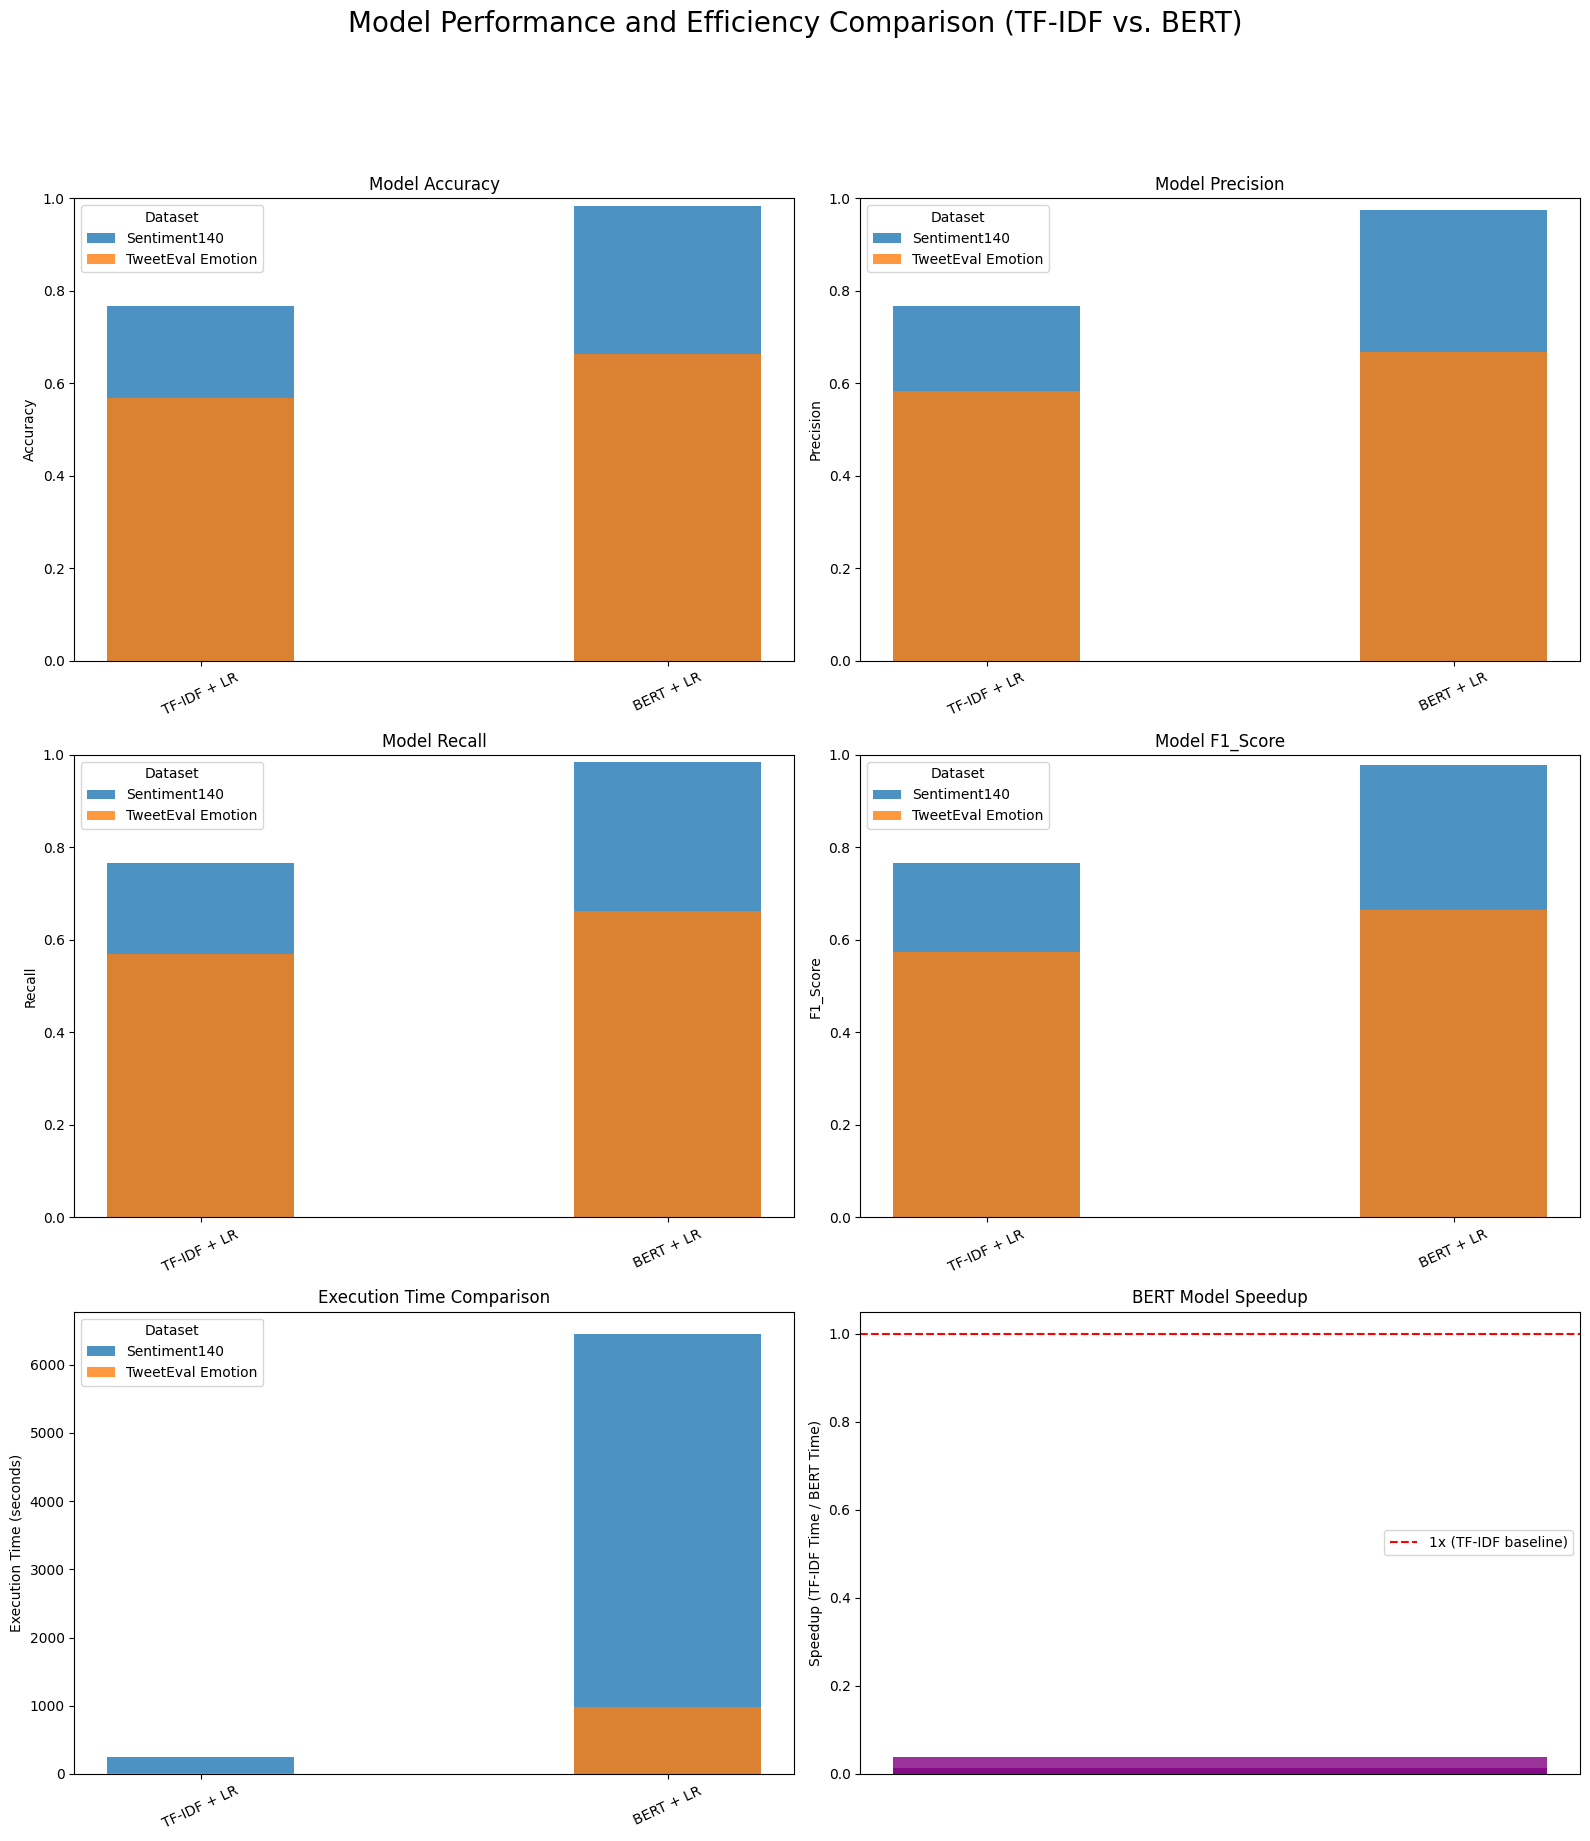

In [14]:
### 3. Final Comparison and Visualization
# =========================================================================================
# 9. Comparison and Visualization - UPDATED to include timing and speedup
# =========================================================================================
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Create a DataFrame for results ---
results = [
    {"Dataset": "Sentiment140", "Model": "TF-IDF + LR", **metrics_s140},
    {"Dataset": "Sentiment140", "Model": "BERT + LR", **metrics_bert_s140},
    {"Dataset": "TweetEval Emotion", "Model": "TF-IDF + LR", **metrics_tweet},
    {"Dataset": "TweetEval Emotion", "Model": "BERT + LR", **metrics_bert_tweet},
]

df_results = pd.DataFrame(results)

# Calculate speedup (time_baseline / time_optimized)
df_results['Speedup'] = None # Initialize column
for dataset in df_results['Dataset'].unique():
    tfidf_time = df_results[(df_results['Dataset'] == dataset) & (df_results['Model'] == 'TF-IDF + LR')]['time_sec'].iloc[0]
    bert_time = df_results[(df_results['Dataset'] == dataset) & (df_results['Model'] == 'BERT + LR')]['time_sec'].iloc[0]
    speedup = tfidf_time / bert_time if bert_time > 0 else float('inf')
    df_results.loc[(df_results['Dataset'] == dataset) & (df_results['Model'] == 'BERT + LR'), 'Speedup'] = speedup

print("✅ Results Summary:")
display(df_results)

# --- 2. Plot comparison charts for all metrics ---
datasets = df_results['Dataset'].unique()
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'time_sec']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 18))
fig.suptitle("Model Performance and Efficiency Comparison (TF-IDF vs. BERT)", fontsize=20, y=1.02)
axes = axes.flatten()

# Plot performance metrics
for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1_score']):
    ax = axes[i]
    for dataset in datasets:
        subset = df_results[df_results['Dataset'] == dataset]
        ax.bar(subset['Model'], subset[metric], label=dataset, alpha=0.8, width=0.4)
    ax.set_ylabel(metric.title())
    ax.set_ylim(0, 1)
    ax.set_title(f"Model {metric.title()}")
    ax.legend(title="Dataset")
    ax.tick_params(axis='x', rotation=25)

# Plot time
ax_time = axes[4]
for dataset in datasets:
    subset = df_results[df_results['Dataset'] == dataset]
    ax_time.bar(subset['Model'], subset['time_sec'], label=dataset, alpha=0.8, width=0.4)
ax_time.set_ylabel("Execution Time (seconds)")
ax_time.set_title("Execution Time Comparison")
ax_time.legend(title="Dataset")
ax_time.tick_params(axis='x', rotation=25)

# Plot speedup
ax_speedup = axes[5]
for dataset in datasets:
    subset = df_results[df_results['Dataset'] == dataset]
    bert_speedup = subset.loc[subset['Model'] == 'BERT + LR', 'Speedup'].iloc[0]
    ax_speedup.bar("BERT + LR", bert_speedup, color='purple', alpha=0.8)
ax_speedup.set_ylabel("Speedup (TF-IDF Time / BERT Time)")
ax_speedup.set_title("BERT Model Speedup")
ax_speedup.tick_params(axis='x', rotation=25)
ax_speedup.set_xticks([])
ax_speedup.axhline(y=1, color='red', linestyle='--', label='1x (TF-IDF baseline)')
ax_speedup.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [15]:
# ======================
# 9. Plotting Code
# ======================
results = [
    {"Dataset": "Sentiment140", "Model": "TF-IDF + LR", **metrics_s140},
    {"Dataset": "Sentiment140", "Model": "BERT + LR", **metrics_bert_s140},
    {"Dataset": "TweetEval Emotion", "Model": "TF-IDF + LR", **metrics_tweet},
    {"Dataset": "TweetEval Emotion", "Model": "BERT + LR", **metrics_bert_tweet},
]

df_results = pd.DataFrame(results)
df_results['Speedup'] = None
for dataset in df_results['Dataset'].unique():
    tfidf_time = df_results[(df_results['Dataset'] == dataset) & (df_results['Model'] == 'TF-IDF + LR')]['time_sec'].iloc[0]
    bert_time = df_results[(df_results['Dataset'] == dataset) & (df_results['Model'] == 'BERT + LR')]['time_sec'].iloc[0]
    speedup = tfidf_time / bert_time if bert_time > 0 else float('inf')
    df_results.loc[(df_results['Dataset'] == dataset) & (df_results['Model'] == 'BERT + LR'), 'Speedup'] = speedup

print("✅ Results Summary:")
display(df_results)

datasets = df_results['Dataset'].unique()

performance_metrics = ['accuracy', 'precision', 'recall', 'f1_score']
for metric in performance_metrics:
    plt.figure(figsize=(8, 6))
    for dataset in datasets:
        subset = df_results[df_results['Dataset'] == dataset]
        plt.bar(subset['Model'], subset[metric], label=dataset, alpha=0.8, width=0.4)
    plt.ylabel(metric.title())
    plt.ylim(0, 1)
    plt.title(f"Model {metric.title()} Comparison")
    plt.legend(title="Dataset")
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.savefig(f"{metric}_chart.png")
    plt.close()

plt.figure(figsize=(8, 6))
for dataset in datasets:
    subset = df_results[df_results['Dataset'] == dataset]
    plt.bar(subset['Model'], subset['time_sec'], label=dataset, alpha=0.8, width=0.4)
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time Comparison")
plt.legend(title="Dataset")
plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig("time_chart.png")
plt.close()

plt.figure(figsize=(8, 6))
for dataset in datasets:
    subset = df_results[df_results['Dataset'] == dataset]
    bert_speedup = subset.loc[subset['Model'] == 'BERT + LR', 'Speedup'].iloc[0]
    plt.bar("BERT + LR", bert_speedup, color='purple', alpha=0.8)
plt.ylabel("Speedup (TF-IDF Time / BERT Time)")
plt.title("BERT Model Speedup")
plt.xticks([])
plt.axhline(y=1, color='red', linestyle='--', label='1x (TF-IDF baseline)')
plt.legend()
plt.tight_layout()
plt.savefig("speedup_chart.png")
plt.close()

✅ Results Summary:


,Dataset,Model,accuracy,f1_score,precision,recall,time_sec,Speedup
0,Sentiment140,TF-IDF + LR,0.766040,0.765934,0.766526,0.766040,250.068422,None
1,Sentiment140,BERT + LR,0.984000,0.979278,0.975307,0.984000,6454.327097,0.038744
2,TweetEval Emotion,TF-IDF + LR,0.568807,0.573979,0.582828,0.568807,14.545881,None
3,TweetEval Emotion,BERT + LR,0.662844,0.664522,0.667777,0.662844,989.128979,0.014706
